<font size="5"><center>Tópicos selectos de ciencia de datos<center><font>
<font size="4"><center>Tarea 4 Ejercicio 3<center>
<center>Iván Vega Gutiérrez<center>

3. Considera de nuevo el corpus `hispablogs.zip` que usaste en la tarea 2 y 3. Complementa todos los modelos de clasificación que usaste para estos datos implementando clasificadores basados en redes recurrentes tipo LSTM y GRU. Usa una capa de embeddings con y sin transfer learning usando pesos pre-entrenados para español. Al final, debes tener los siguientes modelos:

    - Clasificador SVM lineal tomando una representación basada en bolsa de palabras (baseline)
    - Clasificador SVM con representación TF-IDF
    - Clasificador basado en redes convolucionales
    - Clasificador basado en redes recurrentes
    
    a) Haz un breve reporte comparando los resultados, describe tus hallazgos, la parametrización que usaste, y cualquier otro detalle que creas conveniente. Elige el mejor método y explica porqué. 
    
    b) **Competencia opcional**. Finalizaremos la competencia para éstos datos de acuerdo a lo que se especificó en la Tarea 3, ejercicio 2 c).

### Datos

In [1]:
import os
import re

def get_texts_from_dir(cat_dir):
    texts = []
    data_dir = cat_dir
    category_index = {}
    categories = []
    for category_name in sorted(os.listdir(data_dir)):
        category_id = len(category_index)
        category_index[category_name] = category_id
        category_path = os.path.join(data_dir, category_name)
        for f_name in sorted(os.listdir(category_path)):
            f_path = os.path.join(category_path, f_name)
            f = open(f_path, "r", encoding="utf8")
            texts += [f.read()]                
            f.close()
            categories += [category_id]
    print("%d files loaded from %s" % (len(texts), cat_dir))
    return texts, categories, category_index

# Load the RAW text and Category labels
tr_txt, tr_y, tr_y_ind = get_texts_from_dir("/content/drive/MyDrive/Tarea4CienciaDeDatos/hispablogs/train")
te_txt, te_y, te_y_ind = get_texts_from_dir("/content/drive/MyDrive/Tarea4CienciaDeDatos/hispablogs/test")

2253 files loaded from /content/drive/MyDrive/Tarea4CienciaDeDatos/hispablogs/train
1000 files loaded from /content/drive/MyDrive/Tarea4CienciaDeDatos/hispablogs/test


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Procedemos a eliminar stopwords, las cuales son palabras habituales y que aportarían poco al modelo.

In [3]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Clasificador SVM lineal tomando una representación basada en bolsa de palabras (baseline)


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
max_words = 75000
vectorizer = CountVectorizer(lowercase=True,ngram_range=(1,1),stop_words=stop_words,max_features=max_words,binary=False)
vector = vectorizer.fit_transform(tr_txt+te_txt)
bow = vector.toarray()

Dividimos nuestro corpus en los datos de entrenamiento y prueba.

In [5]:
X_train = bow[0:len(tr_txt),:]
X_test = bow[len(tr_txt):,:]

Entrenamiento del modelo

In [6]:
from sklearn import svm 
classifier = svm.SVC(kernel = "linear")
classifier.fit(X_train,tr_y)
y_pred  = classifier.predict(X_test)

# Clasificador SVM con representación TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_words  = 75000
vectorizer_2= TfidfVectorizer(lowercase=True,ngram_range=(1,1),stop_words=stop_words,max_features=max_words,binary=False)
vector_2 = vectorizer_2.fit_transform(tr_txt+te_txt)
tf_idf = vector_2.toarray()
X_train_2 = tf_idf[0:len(tr_txt),:]
X_test_2 = tf_idf[len(tr_txt):,:]
classifier_2 = svm.SVC(kernel = "linear")
classifier_2.fit(X_train_2,tr_y)
y_pred_2  = classifier_2.predict(X_test_2)

## Tokenización y construcción de vocabulario

In [8]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
# Tamaño de vocabulario
tam_vocab = 100000

def tokenizer(inp_str):
    return re.findall(r"\w+",inp_str)

tokenizer = get_tokenizer(None)

def build_vocab(datasets):
    for dataset in datasets:
        for text in dataset:
            yield tokenizer(text)
# El token PAD se fija en el indice cero y el token UNK en el indice uno, y es para palabras que no estén en el vocab
vocab = build_vocab_from_iterator(build_vocab([tr_txt,te_txt]),specials=["<PAD>", "<UNK>"], max_tokens=tam_vocab)
vocab.set_default_index(vocab["<UNK>"])

### Configuración de la GPU para el entrenamiento

In [9]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [10]:
print(device)

cuda


## Data Loaders

Creamos la siguiente clase para para almacenar el texto y sus etiquetras correspondientes, para que posteriormente el DataLoader permita un facil acceso a los datos.

In [11]:
from torch.utils.data import Dataset

class blogsDataset(Dataset):
    def __init__(self,etiquetas,texto):
        self.etiquetas = etiquetas
        self.texto = texto

    def __len__(self):
        return len(self.etiquetas)

    def __getitem__(self, index):
        return self.etiquetas[index],self.texto[index]

Con respecto a los resultados obtenidos en las tareas previas, el número máximo de palabras por blog será de 2,000.  

In [12]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

max_words = 2000
tam_batch = 32
# Creamos los conjuntos de entrenamiento y prueba 
train_data = blogsDataset(tr_y,tr_txt)
test_data = blogsDataset(te_y,te_txt)

train_dataset, test_dataset = to_map_style_dataset(train_data), to_map_style_dataset(test_data)
target_classes = ['ar', 'cl', 'es', 'mx', 'pe']

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    #Llevamos todas las muestras al tamano maximo de palabras
    X = [sample+([0]* (max_words-len(sample))) if len(sample)<max_words else sample[:max_words] for sample in X] 
    return torch.tensor(X, dtype=torch.int32).to(device), torch.tensor(Y).to(device)

train_loader = DataLoader(train_dataset, batch_size=tam_batch, collate_fn=vectorize_batch,shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=tam_batch, collate_fn=vectorize_batch,shuffle=True)

In [13]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([32, 2000]) torch.Size([32])


## Embeddings pre-entrenados (FastText)

A continuación se cargan los vectores pre-entrenados para cada uno de los tokens del vocabulario. Para los tokens que no tengan vectores pre-entrenados se inicializan de manera aleatoria. 

In [14]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

fastext_file = '/content/drive/MyDrive/Tarea4CienciaDeDatos/fasttext-sbwc.vec/fasttext-sbwc.3.6.e20.vec'
wordvector = KeyedVectors.load_word2vec_format(fname=fastext_file, binary=False, limit=None)

def load_pretrained_vectors(word2idx):
    """Load pretrained vectors and create embedding layers.
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """
    d = wordvector.vector_size
    #Iniciamos embeddings aleatorios
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx.lookup_indices(['<PAD>'])] = np.zeros((d,))
    #Cargamos vectores pre-entrenados
    count = 0
    for i in range(1,len(word2idx)):
        word = word2idx.lookup_token(i)
        if word in wordvector.key_to_index:
            count += 1
            embeddings[i] = np.array(wordvector.get_vector(word), dtype=np.float32)

    print(f"Se encontraron {count} / {len(word2idx)} vectores pre-entrenados.")

    return embeddings

Ahora se cargan los vectores pre-entrenados

In [15]:
embeddings = load_pretrained_vectors(vocab)
embeddings = torch.tensor(embeddings,dtype=torch.float32)
embeddings = embeddings.to(device)

Se encontraron 81935 / 100000 vectores pre-entrenados.


In [16]:
embeddings.shape

torch.Size([100000, 300])

La siguiente función se utilizará para crear la capa de embeddings.

In [17]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

## Entrenamiento y evaluación del modelo

In [18]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

## Arquitectura de red neuronal convolucional CNN 

In [19]:
from torch import nn
from torch.nn import functional as F

class CNNClassifier(nn.Module):
    def __init__(self,
                 pretrained_emb=None,
                 tam_embedding=300,
                 n_filtros=100,
                 num_classes=5,
                 tam_kernels=[4,5,6],
                 drop_prop=0.5,
                 tam_inter=100):
        super(CNNClassifier, self).__init__()

        self.n_filtros = n_filtros

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=True)
        else:
            self.tam_embedding = tam_embedding
            self.embedding = nn.Embedding(num_embeddings=len(vocab),embedding_dim=tam_embedding)

        self.convolucion = nn.ModuleList([
            nn.Conv2d(1, n_filtros, (n,tam_embedding), padding=(n-1,0))
            for n in tam_kernels
        ])

        self.lineal1 = nn.Linear(len(tam_kernels)*n_filtros, tam_inter)
        self.lineal2 = nn.Linear(tam_inter,num_classes)

        self.dropout = nn.Dropout(p=drop_prop)

    
    def convolucion_maxPool(self, x, conv):

        x = F.relu(conv(x)).squeeze(3)
        x_max = F.max_pool1d(x,x.size(2)).squeeze(2)
        return x_max
    
    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook


    def forward(self,x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [self.convolucion_maxPool(x, conv) for conv in self.convolucion]

        x = torch.cat(x,1)
        x = self.dropout(x)

        x = self.lineal1(x)
        x = torch.relu(x)
        x = self.lineal2(x)

        return F.softmax(x,dim=1)

### Entrenamiento de modelo CNN sin Transfer Learning

In [20]:
from torch.optim import Adam
# Parametros
pretrained_emb = None
tam_embedding = 300
n_filtros = 120
num_classes = 5
tam_kernels=[3,9]
dropout = 0.5
tam_inter=120
epochs=30
learning_rate=1e-2
loss_fn = nn.CrossEntropyLoss()
# Modelo
cnn_classifier_base=CNNClassifier(pretrained_emb,tam_embedding,n_filtros,num_classes,tam_kernels,dropout,tam_inter)
# Send model to `device` (GPU/CPU)
cnn_classifier_base.to(device)
optimizer = Adam(cnn_classifier_base.parameters(), lr=learning_rate)
TrainModel(cnn_classifier_base, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.698
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.695
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.701
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.692
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.701
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.701
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


### Entrenamiento de modelo CNN con Transfer Learning

In [21]:
# Parametros
pretrained_emb = embeddings
tam_embedding = 300
n_filtros = 120
num_classes = 5
tam_kernels=[3,9]
dropout = 0.5
tam_inter=120
epochs=30
learning_rate=1e-2
loss_fn = nn.CrossEntropyLoss()
# Modelo
cnn_classifier_tl=CNNClassifier(pretrained_emb,tam_embedding,n_filtros,num_classes,tam_kernels,dropout,tam_inter)
# Send model to `device` (GPU/CPU)
cnn_classifier_tl.to(device)
optimizer = Adam(cnn_classifier_tl.parameters(), lr=learning_rate)
TrainModel(cnn_classifier_tl, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.701
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.701
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.698
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.710
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.701
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.704
Valid Acc  : 0.200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.707
Valid Acc  : 0.200


## Arquitectura de redes recurrentes LSTM y GRU

In [22]:
from torch import nn
from torch.nn import functional as F

embed_len = 300
hidden_dim = 50
n_layers=1

# Modelo RNN
class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embedding = embeddings.to(device)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim).to(device))
        return self.linear(output[:,-1])

# Modelo LSTM
class LSTMClassifier(nn.Module):
    def __init__(self,pretrained_emb):
        super(LSTMClassifier, self).__init__()
        if pretrained_emb is not None:
            self.embedding_layer, num_embeddings, embedding_dim = create_emb_layer(pretrained_emb, True)
        else:
            self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = embeddings.to(device)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden.to(device), carry.to(device)))
        return self.linear(output[:,-1])
# Modelo GRU   
class GRUClassifier(nn.Module):
    def __init__(self,pretrained_emb):
        super(GRUClassifier, self).__init__()
        if pretrained_emb is not None:
            self.embedding_layer, num_embeddings, embedding_dim = create_emb_layer(pretrained_emb, True)
        else:
            self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.gru = nn.GRU(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = embeddings.to(device)
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim)
        output, hidden = self.gru(embeddings, hidden.to(device))
        return self.linear(output[:,-1])

### Entrenamiento de modelo LSTM sin Transfer Learning

In [23]:
epochs = 30
learning_rate = 1e-2
pretrained_emb = None

loss_fn = nn.CrossEntropyLoss()
lstm_classifier_base = LSTMClassifier(pretrained_emb)
lstm_classifier_base.to(device)
optimizer = Adam(lstm_classifier_base.parameters(), lr=learning_rate)

TrainModel(lstm_classifier_base, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.620


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.610
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.678
Valid Acc  : 0.204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.745
Valid Acc  : 0.185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.792
Valid Acc  : 0.226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.807
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.886
Valid Acc  : 0.222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.887
Valid Acc  : 0.223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.903
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.901
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.897
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.911
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.928
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.002
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.986
Valid Acc  : 0.219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.946
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.993
Valid Acc  : 0.217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.970
Valid Acc  : 0.212


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.019
Valid Acc  : 0.218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.719


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.990
Valid Acc  : 0.215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.993
Valid Acc  : 0.192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.028
Valid Acc  : 0.218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.021
Valid Acc  : 0.217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.023
Valid Acc  : 0.218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.046
Valid Acc  : 0.219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.023
Valid Acc  : 0.218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.026
Valid Acc  : 0.219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.050
Valid Acc  : 0.219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.053
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.040
Valid Acc  : 0.187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.050
Valid Acc  : 0.220


### Entrenamiento de modelo LSTM con Transfer Learning

In [24]:
epochs = 30
learning_rate = 1e-2
pretrained_emb = embeddings

loss_fn = nn.CrossEntropyLoss()
lstm_classifier_tl = LSTMClassifier(pretrained_emb)
lstm_classifier_tl.to(device)
optimizer = Adam(lstm_classifier_tl.parameters(), lr=learning_rate)

TrainModel(lstm_classifier_tl, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.613
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.622
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.649
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.698
Valid Acc  : 0.234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.744
Valid Acc  : 0.225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.901


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.856
Valid Acc  : 0.227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.947
Valid Acc  : 0.230


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.999
Valid Acc  : 0.226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.048
Valid Acc  : 0.225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.725


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.032
Valid Acc  : 0.230


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.039
Valid Acc  : 0.224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.024
Valid Acc  : 0.231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.710


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.063
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.084
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.075
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.067
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.063
Valid Acc  : 0.227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.081
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.111
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.135
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.093
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.068
Valid Acc  : 0.231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.089
Valid Acc  : 0.229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.089
Valid Acc  : 0.230


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.710


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.080
Valid Acc  : 0.231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.039
Valid Acc  : 0.223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.931
Valid Acc  : 0.222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.951
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.961
Valid Acc  : 0.228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.097
Valid Acc  : 0.232


### Entrenamiento de modelo GRU sin Transfer Learning

In [25]:
epochs = 30
learning_rate = 1e-2
pretrained_emb = None

loss_fn = nn.CrossEntropyLoss()
gru_classifier_base = GRUClassifier(pretrained_emb)
gru_classifier_base.to(device)
optimizer = Adam(gru_classifier_base.parameters(), lr=learning_rate)

TrainModel(gru_classifier_base, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.652


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.681
Valid Acc  : 0.217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.770
Valid Acc  : 0.226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.000
Valid Acc  : 0.209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.350
Valid Acc  : 0.204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.680
Valid Acc  : 0.218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.903
Valid Acc  : 0.214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.000
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.117
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.171
Valid Acc  : 0.224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.332
Valid Acc  : 0.211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.342
Valid Acc  : 0.208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.426
Valid Acc  : 0.211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.500
Valid Acc  : 0.216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.522
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.551
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.623
Valid Acc  : 0.219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.644
Valid Acc  : 0.216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.658
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.704
Valid Acc  : 0.222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.731
Valid Acc  : 0.222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.759
Valid Acc  : 0.222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.786
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.830
Valid Acc  : 0.224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.900
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.854
Valid Acc  : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.910
Valid Acc  : 0.223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.909
Valid Acc  : 0.222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.971
Valid Acc  : 0.226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.969
Valid Acc  : 0.226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 3.971
Valid Acc  : 0.224


### Entrenamiento de modelo GRU con Transfer Learning

In [26]:
epochs = 30
learning_rate = 1e-2
pretrained_emb = embeddings

loss_fn = nn.CrossEntropyLoss()
gru_classifier_tl = GRUClassifier(pretrained_emb)
gru_classifier_tl.to(device)
optimizer = Adam(gru_classifier_tl.parameters(), lr=learning_rate)

TrainModel(gru_classifier_tl, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.619
Valid Acc  : 0.220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.608
Valid Acc  : 0.245


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 1.185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.234
Valid Acc  : 0.489


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.112
Valid Acc  : 0.627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.057
Valid Acc  : 0.643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.180
Valid Acc  : 0.626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.186
Valid Acc  : 0.651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.251
Valid Acc  : 0.646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.498
Valid Acc  : 0.623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.627
Valid Acc  : 0.623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.687
Valid Acc  : 0.611


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.099


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.688
Valid Acc  : 0.605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.746
Valid Acc  : 0.644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.918
Valid Acc  : 0.601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.060


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.877
Valid Acc  : 0.620


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.696
Valid Acc  : 0.613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.993
Valid Acc  : 0.598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.670
Valid Acc  : 0.621


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.190


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.654
Valid Acc  : 0.623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.734
Valid Acc  : 0.627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.968
Valid Acc  : 0.601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.031


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.988
Valid Acc  : 0.617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.030


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.969
Valid Acc  : 0.617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.921
Valid Acc  : 0.627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 1.939
Valid Acc  : 0.625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.056
Valid Acc  : 0.627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.082
Valid Acc  : 0.617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.141
Valid Acc  : 0.615


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.164
Valid Acc  : 0.625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

Train Loss : 0.045


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/32 [00:00<?, ?it/s]

Valid Loss : 2.190
Valid Acc  : 0.583


## Resultados

A continuación se hacen las respectivas predicciones de cada modelo.

In [27]:
Y_actual_cnn, Y_preds_cnn = MakePredictions(cnn_classifier_base, test_loader)
Y_actual_cnn_tl, Y_preds_cnn_tl = MakePredictions(cnn_classifier_tl, test_loader)
Y_actual_lstm, Y_preds_lstm = MakePredictions(lstm_classifier_base, test_loader)
Y_actual_lstm_tl, Y_preds_lstm_tl = MakePredictions(lstm_classifier_tl, test_loader)
Y_actual_gru, Y_preds_gru = MakePredictions(gru_classifier_base, test_loader)
Y_actual_gru_tl, Y_preds_gru_tl = MakePredictions(gru_classifier_tl, test_loader)

Imprimirmos las métricas de cada modelo

In [28]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# SVM-BOW
print('=================== SVM -BOW =======================')
print(metrics.classification_report(te_y, y_pred))
# SVM-TF-IDF
print('=================== SVM TF-IDF =======================')
print(metrics.classification_report(te_y, y_pred_2))
# CNN sin TL
print('=================== CNN sin Transfer Learning =======================')
print("Test Accuracy : {}".format(accuracy_score(Y_actual_cnn, Y_preds_cnn)))
print("\nClassification Report : ")
print(classification_report(Y_actual_cnn, Y_preds_cnn, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_cnn, Y_preds_cnn))
# CNN con TL
print('=================== CNN con Transfer Learning =======================')
print("Test Accuracy : {}".format(accuracy_score(Y_actual_cnn_tl, Y_preds_cnn_tl)))
print("\nClassification Report : ")
print(classification_report(Y_actual_cnn_tl, Y_preds_cnn_tl, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_cnn_tl, Y_preds_cnn_tl))
# LSTM sin TL
print('=================== LSTM sin Transfer Learning =======================')
print("Test Accuracy : {}".format(accuracy_score(Y_actual_lstm, Y_preds_lstm)))
print("\nClassification Report : ")
print(classification_report(Y_actual_lstm, Y_preds_lstm, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_lstm, Y_preds_lstm))
# LSTM con TL
print('=================== LSTM con Transfer Learning =======================')
print("Test Accuracy : {}".format(accuracy_score(Y_actual_lstm_tl, Y_preds_lstm_tl)))
print("\nClassification Report : ")
print(classification_report(Y_actual_lstm_tl, Y_preds_lstm_tl, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_lstm_tl, Y_preds_lstm_tl))
# GRU sin TL
print('=================== GRU sin Transfer Learning =======================')
print("Test Accuracy : {}".format(accuracy_score(Y_actual_gru, Y_preds_gru)))
print("\nClassification Report : ")
print(classification_report(Y_actual_gru, Y_preds_gru, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_gru, Y_preds_gru))
# GRU con TL
print('=================== GRU con Transfer Learning =======================')
print("Test Accuracy : {}".format(accuracy_score(Y_actual_gru_tl, Y_preds_gru_tl)))
print("\nClassification Report : ")
print(classification_report(Y_actual_gru_tl, Y_preds_gru_tl, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_gru_tl, Y_preds_gru_tl))

=================== SVM -BOW =======================
              precision    recall  f1-score   support

           0       0.68      0.33      0.44       200
           1       0.29      0.94      0.44       200
           2       0.75      0.39      0.51       200
           3       0.72      0.27      0.39       200
           4       0.79      0.28      0.42       200

    accuracy                           0.44      1000
   macro avg       0.65      0.44      0.44      1000
weighted avg       0.65      0.44      0.44      1000

=================== SVM TF-IDF =======================
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       200
           1       0.53      0.83      0.65       200
           2       0.70      0.78      0.73       200
           3       0.78      0.52      0.62       200
           4       0.75      0.60      0.67       200

    accuracy                           0.66      1000
   macro avg       0.69

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Mostramos la matriz de confusión de cada modelo

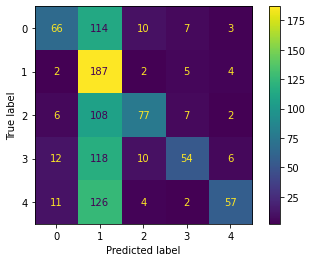

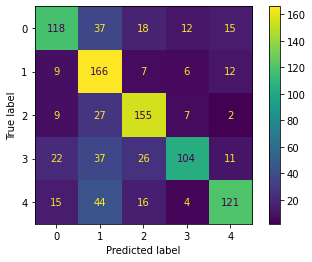

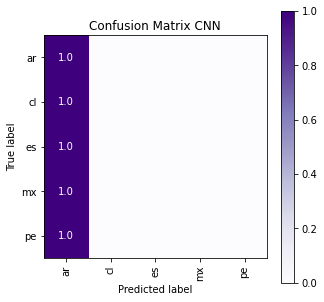

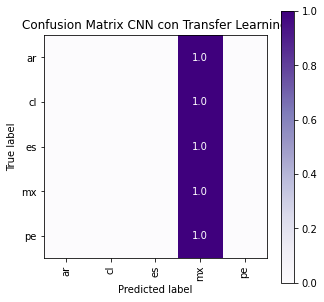

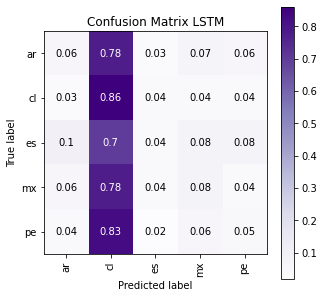

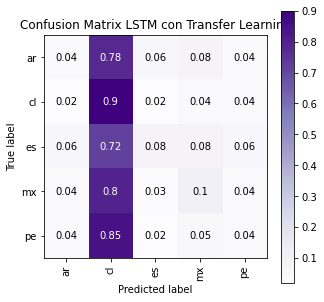

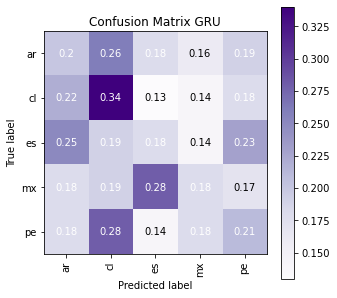

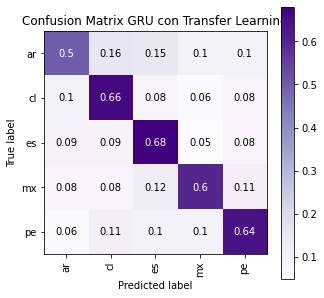

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import numpy as np


#SVM-BOW
cm = metrics.confusion_matrix(te_y, y_pred, labels=classifier.classes_, normalize =None)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
#SVM-TF-IDF
cm = metrics.confusion_matrix(te_y, y_pred_2, labels=classifier_2.classes_, normalize =None)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_2.classes_)
disp.plot()
plt.show()
# CNN sin TL
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_cnn], [target_classes[i] for i in Y_preds_cnn],
                                    normalize=True,
                                    title="Confusion Matrix CNN",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);
# CNN con TL
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_cnn_tl], [target_classes[i] for i in Y_preds_cnn_tl],
                                    normalize=True,
                                    title="Confusion Matrix CNN con Transfer Learning",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);
# LSTM sin TL
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_lstm], [target_classes[i] for i in Y_preds_lstm],
                                    normalize=True,
                                    title="Confusion Matrix LSTM",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);
# LSTM con TL
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_lstm_tl], [target_classes[i] for i in Y_preds_lstm_tl],
                                    normalize=True,
                                    title="Confusion Matrix LSTM con Transfer Learning",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);
# GRU sin TL
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_gru], [target_classes[i] for i in Y_preds_gru],
                                    normalize=True,
                                    title="Confusion Matrix GRU",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);
# GRU con TL
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_gru_tl], [target_classes[i] for i in Y_preds_gru_tl],
                                    normalize=True,
                                    title="Confusion Matrix GRU con Transfer Learning",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## Conclusiones

A partir de los resultados obtenidos, podemos observar diferencias significativas entre cada modelo. Lo primero que notamos es que los peores resultados los obtuvimos utilizando redes neuronales convolucionales. Al ocupar el modelo base de una CNN observamos que todas las etiquetas las manda al país de Argentina, al utilizar transfer learning el comportamiento sigue siendo prácticamente el mismo, pues todos los blogs los etiqueta como si fueran de México, por lo tanto, concluimos que para realizar esta tarea de claisificación, un modelo CNN es la peor opción, o al menos con los parámetros que utilizamos, aunque se revisó el código varias veces no se enconró si existe algún error que sea la causa de obtenener una clasificación de esta manera. 

Por otro lado, tenemos los claisifcadores SVM con representación basada en bolsa de palabras y con representación TF-IDF. De estos modelos podemos observar buenos resultados, el f1-score de la representación BOW es de 0.44, un resultado no tan malo, sin embargo, al utilizar la representación TF-IDF se obtiene un f1-score de 0.66, por lo tanto, una buea opción para clasificación de blogs sería utilizar el clasificador SVM con representación TF-IDF, ya que el modelo es simple y fácil de implementar.

Pot último, tenemos que las redes neuronales recurrentes, las cuales lograron un mejor desempeño que las CNN's en general, no obstante, la red LSTM a pesar que hizo una clasificación mejor que las redes convolucionales, puesto que las etiquetas ya no las manda a un solo país, se observa que sigue existiendo un comportamiento similar a las CNN's, ya que la mayoría de los blos los clasifica provenientes del país de Chile, por lo tanto no se recomienda utilizar una red LSTM (con o sin transfer learning), o al menos no con los parámetros establecidos, además que no lograron un mejor desempeño que los clasificadores SVM con BOW y TF-IDF. Finalmente, la implementación de una red GRU sin transfer learning, rompe con el raro comportamiento de etiquetar la mayoría de los blogs a un solo país, en la matríz de confusión se observa una clasificación más homogenea, a pesar de eso, las métricas son iguales que la de los modelos LSTM,teniendo un f1-score de 0.22. Sorprendentemente al utilizar una red GRU con transfer learning, se logra mejorar los resultados considerablemente hasta alcanzar un f1-score de 0.62, la clasificación la hace de manera correcta para cada blog y no se observa ningún tipo de sesgo hacia un país en particular.

Con todo lo anterior, concluimos que los mejores resultados se obtuvieron con el clasificador SVM con representación TF-IDF y con una red GRU con transfer learning. A pesar que el clasificaddor SVM TF-IDF dio ligeramente mejores resultados, el modelo que se recomendaría utilizar es una red GRU con transrfer learning, ya que podemos ajustar los parámetros y lograr mejores resultados, como trabajo adicional sería reajustar los parámetros de las redes CNN y entender porque genera una clasificación de esa manera.